<a href="https://colab.research.google.com/github/callumselv/Y4_project/blob/main/Lohani_2021_2d_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 16.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/ColabPackages

In [ ]:
!pip install --target=/content/drive/MyDrive/ColabPackages qutip

  Using cached qutip-5.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.4 MB/s eta 0:00:00
Using cached qutip-5.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (28.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ColabPackages')

import qutip as qt

# Verify the installation
print(qt.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
5.0.4


In [ ]:
import numpy as np
from qutip import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import sqrtm

In [ ]:
from matplotlib.pyplot import rcParams
rcParams['font.size'] = '16'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['figure.figsize'] = (8, 5)

In [ ]:
no_data = 30000
d = 2
dimension = 2**d

In [ ]:
def gen_rhos_chos(no_data, d):
    dimension = 2**d
    rhos = np.zeros((no_data,dimension,dimension),dtype=complex)

    eta = 1e-7

    # Generate random density matrices with eta adjustment to avoid issues in Cholesky decomposition
    for i in range(no_data):
        random_unitary = unitary_group.rvs(dimension)
        coeffs = random_unitary[:,0]
        rho = np.outer(coeffs,coeffs.conj())
        rhos[i] = (1-eta)*rho + (eta/4)*np.eye(dimension)

    # Calculate Cholesky decomposition of density matrices
    cholesky_decompositions = np.array([np.linalg.cholesky(rho) for rho in rhos])

    return rhos,cholesky_decompositions

In [ ]:
def generate_index_pairs(d):
    dimension = 2**d
    index_num = int(dimension*(dimension-1)/2)
    pairs = np.zeros((index_num,2), dtype=int)
    index=0
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs[index] = (i, j)
            index+=1

    return pairs

In [ ]:
ind = generate_index_pairs(d)
ind

array([[1, 0],
       [2, 1],
       [3, 2],
       [2, 0],
       [3, 1],
       [3, 0]])

In [ ]:
def gen_taus(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index] = cholesky[i, j].real
            extracted_values[index + 1] = cholesky[i, j].imag
            index += 2

        all_taus[no] = extracted_values

    return all_taus

In [ ]:
# Make 6^d projectors of Pauli {X,Y,Z} operators

paulis = [sigmax(),sigmay(),sigmaz()]
evectors = np.zeros((6,2,1),dtype=complex)

i=0
for pauli in paulis:
    vals, vecs = pauli.eigenstates()
    evectors[i] = vecs[0][:]
    evectors[i+1] = vecs[1][:]
    i += 2

projectors = np.zeros((6,2,2), dtype=complex)

for i, vectors in enumerate(evectors):
    projectors[i] = np.outer(vectors,vectors.conj())

In [ ]:
pauli_2d = np.zeros((6**2,4,4), dtype=complex)

index=0
for i in projectors:
    for j in projectors:
        pauli_2d[index] = np.kron(i,j)
        index += 1

In [ ]:
pauli_3d = np.zeros((6**3,2**3,2**3), dtype=complex)

index=0
for i in pauli_2d:
    for j in projectors:
        pauli_3d[index] = np.kron(i,j)
        index += 1

In [ ]:
def gen_nvals_taus_rhos(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index_tau=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index_tau = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index_tau] = cholesky[i, j].real
            extracted_values[index_tau + 1] = cholesky[i, j].imag
            index_tau += 2

        all_taus[no] = extracted_values

    nvals = np.zeros((no_data,6**d))

    for i1,rho in enumerate(rhos):
      for index,proj in enumerate(pauli_2d):
          nvals[i1,index] = np.trace(rho@proj)

    return nvals, all_taus, rhos

In [ ]:
# Recontructs density matrix from tau values predicted by neural network

def reconstruct_matrix_nn(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)
    rho = rho/np.trace(rho)

    return rho

In [ ]:
# Reconstructs density matrix from true tau values

def reconstruct_matrix_t(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)

    return rho

In [ ]:
def fidelity(rho_t, rho_nn):
    sqrt_nn = sqrtm(rho_nn)
    matrix = sqrt_nn@rho_t@sqrt_nn
    tr = np.trace(sqrtm(matrix))
    return np.abs(tr)**2

In [ ]:
def fid_taus(tau_t, tau_nn):
    rho_t = reconstruct_matrix_t(tau_t)
    rho_nn = reconstruct_matrix_nn(tau_nn)
    return fidelity(rho_t, rho_nn)

In [ ]:
def generate_index_pairs_tf(d):
    dimension = 2 ** d
    pairs_list = []
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs_list.append([i, j])
    pairs = tf.constant(pairs_list, dtype=tf.int32)
    return pairs

def reconstruct_matrix_nn_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    traces = tf.linalg.trace(rhos)
    traces = tf.reshape(traces, [-1, 1, 1])
    rhos_normalized = rhos / traces

    return rhos_normalized

def reconstruct_matrix_t_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    return rhos

'''
def fidelity_tf(rho_t, rho_nn):
    sqrt_nn = tf.linalg.sqrtm(rho_nn)
    intermediate = tf.matmul(sqrt_nn, tf.matmul(rho_t, sqrt_nn))
    sqrt_intermediate = tf.linalg.sqrtm(intermediate)
    trace = tf.math.real(tf.linalg.trace(sqrt_intermediate))
    fidelity = tf.square(tf.abs(trace))
    return fidelity
'''

def fidelity_tf(rho_t, rho_nn):
    product = tf.matmul(rho_t, rho_nn)
    trace = tf.linalg.trace(product)
    return tf.abs(trace)


def fid_taus_tf(tau_t, tau_nn, d):
    rho_t = reconstruct_matrix_t_tf(tau_t, d)
    rho_nn = reconstruct_matrix_nn_tf(tau_nn, d)
    fidelities = fidelity_tf(rho_t, rho_nn)
    return fidelities

In [ ]:
def fidelity_metric(y_true, y_pred):
    return fid_taus_tf(y_true, y_pred, d)

In [ ]:
dense1 = 750
dense2 = 450

In [ ]:
def build_cnn_model():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(6**d,)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))

    model.add(Flatten())

    model.add(Dense(dense1, activation='relu'))

    model.add(Dense(dense2, activation='relu'))

    model.add(Dense(2**(2*d), activation='linear'))

    return model

model = build_cnn_model()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 25)            │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 750)                 │          19,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 367,316 (1.40 MB)

 Trainable params: 367,316 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
nvals,all_taus,rhos = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_start_time = time.time()
        self.cumulative_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_duration)
        cumulative_time = time.time() - self.train_start_time
        self.cumulative_times.append(cumulative_time)


In [ ]:
class InMemoryModelSaver(tf.keras.callbacks.Callback):
    def __init__(self, save_freq_epochs=20):
        super(InMemoryModelSaver, self).__init__()
        self.save_freq_epochs = save_freq_epochs
        self.saved_models = {}

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1

        if (epoch_num - 1) % self.save_freq_epochs == 0:
            cloned_model = tf.keras.models.clone_model(self.model)

            cloned_model.compile(
                optimizer=self.model.optimizer.__class__.from_config(self.model.optimizer.get_config()),
                loss=self.model.loss,
                metrics=self.model.metrics
            )

            cloned_model.set_weights(self.model.get_weights())

            self.saved_models[epoch_num] = cloned_model

            print(f'\n[InMemoryModelSaver] Model cloned and saved in memory at epoch {epoch_num}.')

In [ ]:
def build_cnn_model_layers():
    model = Sequential()

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model
model = build_cnn_model_layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 750)                 │          27,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │          12,016 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,766 (155.34 KB)

 Trainable params: 39,766 (155.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
time_callback1 = TimeHistory()

model1_layer = build_cnn_model_layers()
model1_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver1 = InMemoryModelSaver(save_freq_epochs=10)

history1 = model1_layer.fit(
    nvals, all_taus,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback1, model_saver1]
    )

Epoch 1/300
229/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0713 - mean_squared_error: 0.0202
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0699 - mean_squared_error: 0.0197 - val_loss: 0.0215 - val_mean_squared_error: 0.0034
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mean_squared_error: 0.0028 - val_loss: 0.0146 - val_mean_squared_error: 0.0019
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - mean_squared_error: 0.0017 - val_loss: 0.0129 - val_mean_squared_error: 0.0014
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - mean_squared_error: 0.0013 - val_loss: 0.0101 - val_mean_squared_error: 0.0011
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094 - mean_squared_error: 9.7993e-04 - val_loss: 0.0101 - val_mean_squared_error: 9.0673e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - mean_squared_error: 9.0007

Text(0, 0.5, 'Validation loss')

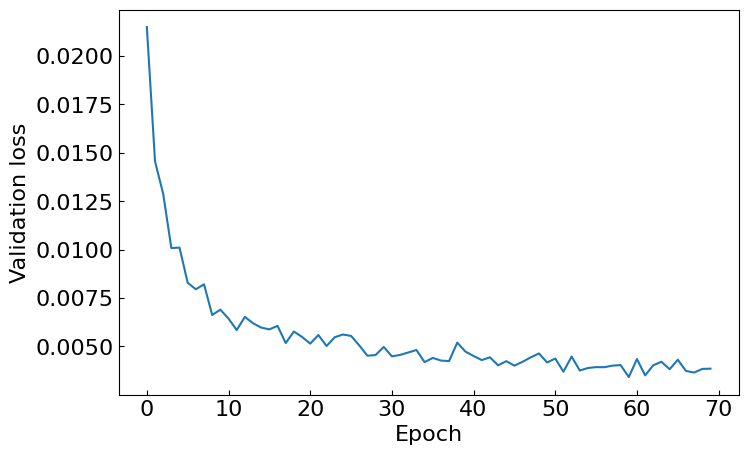

In [ ]:
plt.plot(history1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

In [ ]:
len(history1.history['val_loss'])

70

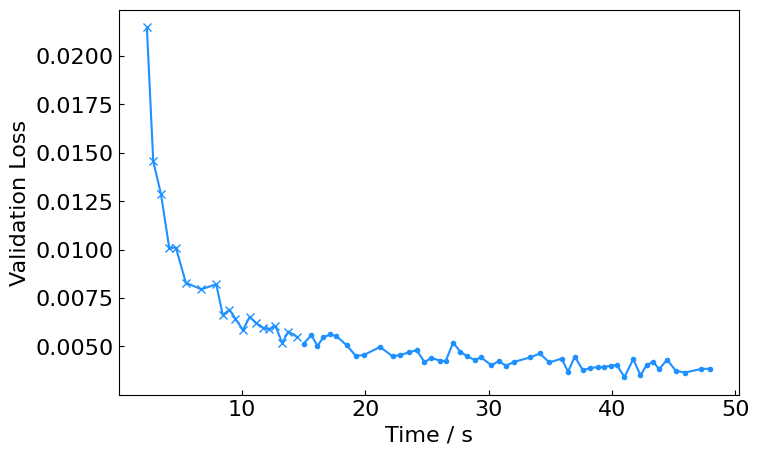

In [ ]:
epoch_durations1 = time_callback1.epoch_times
cumulative_times1 = time_callback1.cumulative_times
change_mark = 20

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='Training Loss', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
test_no = 500
n_tests, tau_tests, rho_tests = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
def predict_with_saved_models(saved_models, epochs_to_predict, X_input):
    predictions = {}

    for epoch_num in epochs_to_predict:
        model = saved_models.get(epoch_num)
        if model is not None:
            preds = model.predict(X_input)
            predictions[epoch_num] = preds
    return predictions

In [ ]:
epochs = len(history1.history['val_loss'])

epochs_saved = np.arange(1,epochs,10)

In [ ]:
tau_nns_int = predict_with_saved_models(model_saver1.saved_models, epochs_saved, n_tests)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
fidelities_int = np.zeros((len(epochs_saved),test_no))
fidelities_plot = np.zeros(len(epochs_saved))
fidelities_int_err = np.zeros(len(epochs_saved))
for index,val in enumerate(epochs_saved):
    i=0
    for nns, tests in zip(tau_nns_int[val],tau_tests):
        fidelities_int[index,i] = fid_taus(tests,nns)
        i+=1
    fidelities_int_err[index] = np.std(fidelities_int[index])/np.sqrt(test_no)
    fidelities_plot[index] = np.mean(fidelities_int[index])

In [ ]:
tau_nns = model1_layer.predict(n_tests)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
fidelities = np.zeros(len(tau_nns))
index = 0
fid = 0
for nns, tests in zip(tau_nns,tau_tests):
    fid += fid_taus(tests,nns)
    fidelities[index] = fid_taus(tests,nns)
    index += 1
fid_err = np.std(fidelities)/np.sqrt(test_no)
fid = np.mean(fidelities)

In [ ]:
fidelities = np.append(fidelities_plot,fid)
fidelities_err = np.append(fidelities_int_err, fid_err)

In [ ]:
epochs_fin = np.append(epochs_saved,epochs)
epochs_fin

array([ 1, 11, 21, 31, 41, 51, 61, 70])

In [ ]:
times_saved = np.zeros(len(epochs_fin))
index=0
for i in epochs_fin:
    times_saved[index] = cumulative_times1[i-1]
    index+=1

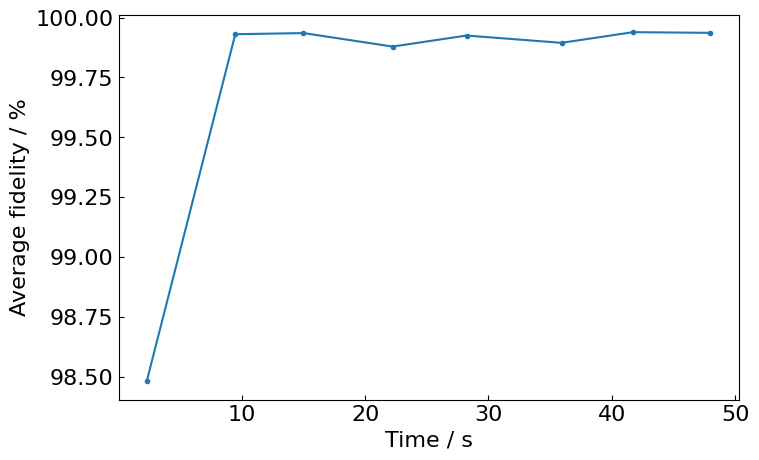

In [ ]:
plt.errorbar(times_saved, fidelities*100, yerr=fidelities_err, linestyle = '-', marker='.')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.show()

In [ ]:
print(f'Average fidelity over {len(tau_nns)} test matrices is {np.mean(fidelities)*100:.2f} ± {np.std(fidelities)*100/np.sqrt(len(fidelities)):.2f} %')

Average fidelity over 500 test matrices is 99.74 ± 0.17 %


In [ ]:
def build_cnn_model_2layers():
    model = Sequential()

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_2layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 750)                 │          27,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 372,916 (1.42 MB)

 Trainable params: 372,916 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nvals2,all_taus2,rhos2 = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
time_callback2 = TimeHistory()

model2_layer = build_cnn_model_2layers()
model2_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver2 = InMemoryModelSaver(save_freq_epochs=10)

history2 = model1_layer.fit(
    nvals2, all_taus2,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback2, model_saver2]
    )

Epoch 1/300
 20/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mean_squared_error: 1.8276e-04  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mean_squared_error: 1.8918e-04
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mean_squared_error: 1.8904e-04 - val_loss: 0.0037 - val_mean_squared_error: 1.7798e-04
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mean_squared_error: 1.7676e-04 - val_loss: 0.0037 - val_mean_squared_error: 1.6931e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mean_squared_error: 1.6694e-04 - val_loss: 0.0038 - val_mean_squared_error: 1.9305e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - mean_squared_error: 1.7410e-04 - val_loss: 0.0037 - val_mean_squared_error: 1.7416e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - mean_squared_error: 1.5771e-04 - val_loss: 0.0036 - val_mean_squared_error: 1.7596e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - me

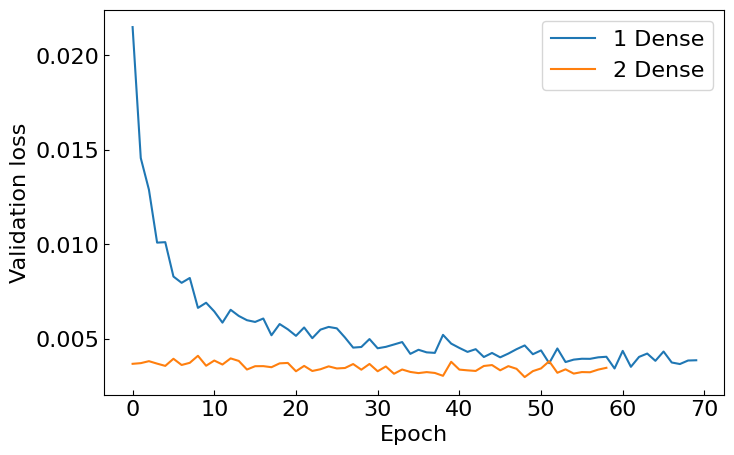

In [ ]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

In [ ]:
len(history2.history['val_loss'])

70

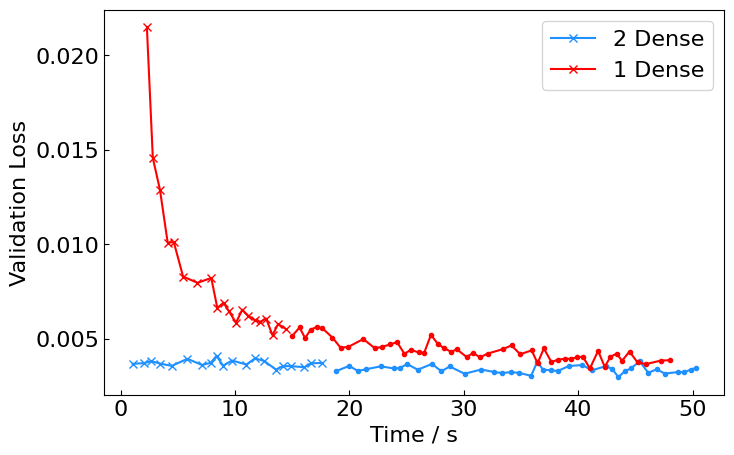

In [ ]:
cumulative_times2 = time_callback2.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
test_no = 500
n_tests2, tau_tests2, rho_tests2 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
epochs2 = len(history2.history['val_loss'])

epochs_saved2 = np.arange(1,epochs2,10)

tot_epochs2 = np.append(epochs_saved2, epochs2)

In [ ]:
tau_nns_int2 = predict_with_saved_models(model_saver2.saved_models, epochs_saved2, n_tests2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
tau_nns2 = model2_layer.predict(n_tests2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
def fidelities_epochs(tau_nns, tau_tests, tau_nns_int, epochs_saved, epochs, cumulative_times, test_no=test_no):

    fidelities_int = np.zeros((len(epochs_saved),test_no))
    fidelities_plot = np.zeros(len(epochs_saved))
    fidelities_int_err = np.zeros(len(epochs_saved))

    for idx, epoch in enumerate(epochs_saved):
        for test_idx, (nns, tests) in enumerate(zip(tau_nns_int[epoch], tau_tests)):
            fidelities_int[idx, test_idx] = fid_taus(tests, nns)
        fidelities_plot[idx] = np.mean(fidelities_int[idx])
        fidelities_int_err[idx] = np.std(fidelities_int[idx]) / np.sqrt(test_no)

    fidelities = np.zeros(len(tau_nns))
    index = 0
    for nns, tests in zip(tau_nns,tau_tests):
        fidelities[index] = fid_taus(tests,nns)
        index += 1
    fid_err = np.std(fidelities)/np.sqrt(test_no)
    fid = np.mean(fidelities)

    fidelities = np.append(fidelities_plot,fid)
    fidelities_err = np.append(fidelities_int_err, fid_err)

    epochs_fin = np.append(epochs_saved,epochs)
    times_saved = np.zeros(len(epochs_fin))
    index=0
    for i in epochs_fin:
        times_saved[index] = cumulative_times[i-1]
        index+=1

    return times_saved, fidelities, fidelities_err

In [ ]:
def fidelities_epochs(
    tau_nns,
    tau_tests,
    tau_nns_int,
    epochs_saved,
    additional_epochs,
    cumulative_times,
    test_no=test_no
):
    """
    Calculate fidelities for saved epochs and overall fidelity.

    Parameters:
    - tau_nns: array-like, input data for fidelities.
    - tau_tests: array-like, test data corresponding to tau_nns.
    - tau_nns_int: list of arrays, indexed by epoch number (1-based), containing intermediate data.
    - epochs_saved: list or array of epoch numbers where fidelities are saved (1-based).
    - cumulative_times: array-like, cumulative times corresponding to each epoch.
    - additional_epochs: list or array of additional epoch numbers to include.
    - test_no: int, number of tests per epoch.

    Returns:
    - times_saved: array, cumulative times for saved and additional epochs.
    - fidelities: array, mean fidelities per saved epoch plus overall mean fidelity.
    - fidelities_err: array, standard errors for fidelities per saved epoch plus overall standard error.
    """

    # Initialize arrays to store fidelities and errors
    fidelities_int = np.zeros((len(epochs_saved), test_no))
    fidelities_plot = np.zeros(len(epochs_saved))
    fidelities_int_err = np.zeros(len(epochs_saved))

    # Calculate fidelities for each saved epoch
    for idx, epoch in enumerate(epochs_saved):
        for test_idx, (nns, tests) in enumerate(zip(tau_nns_int[epoch], tau_tests)):
            fidelities_int[idx, test_idx] = fid_taus(tests, nns)
        fidelities_plot[idx] = np.mean(fidelities_int[idx])
        fidelities_int_err[idx] = np.std(fidelities_int[idx]) / np.sqrt(test_no)

    # Calculate overall fidelity across all tau_nns and tau_tests
    fidelities_overall = np.array([fid_taus(tests, nns) for nns, tests in zip(tau_nns, tau_tests)])
    fid = np.mean(fidelities_overall)
    fid_err = np.std(fidelities_overall) / np.sqrt(test_no)

    # Append overall fidelity to per-epoch fidelities
    fidelities = np.append(fidelities_plot, fid)
    fidelities_err = np.append(fidelities_int_err, fid_err)

    # Combine saved epochs with additional epochs
    epochs_fin = np.append(epochs_saved, epochs)

    # Initialize times_saved array
    times_saved = np.zeros(len(epochs_fin))

    # Populate times_saved based on epoch numbers
    for idx, epoch in enumerate(epochs_fin):
        # Adjust indexing: if epoch is 1-based and cumulative_times is 0-based
        if epoch - 1 < len(cumulative_times):
            times_saved[idx] = cumulative_times[epoch - 1]
        else:
            print(f"Warning: Epoch {epoch} is out of bounds for cumulative_times.")
            times_saved[idx] = np.nan  # Assign NaN or handle as appropriate

    # Debugging: Print the computed fidelities and errors
    print("Fidelities Plot (Per Saved Epoch):", fidelities_plot)
    print("Final Fidelity:", fid)
    print("Fidelities:", fidelities)
    print("Fidelities Error:", fidelities_err)
    print("Epochs Fin:", epochs_fin)
    print("Times Saved:", times_saved)

    return times_saved, fidelities, fidelities_err

In [ ]:
times_saved2, fidelities2, fidelities_err2 = fidelities_epochs(tau_nns2, tau_tests2, tau_nns_int2, epochs_saved2, epochs2, cumulative_times2)

Fidelities Plot (Per Saved Epoch): [1.00004116 0.99989204 1.00004116 1.00001491 0.99999867 1.00003063]
Overall Fidelity (fid): 0.2422481637609515
Epochs to Plot: [ 1 11 21 31 41 51 59]
Times Saved: [ 1.05389452  9.73358154 18.81695819 28.03038883 36.91634202 44.59653664
 50.30254889]


In [ ]:
times_saved1, fidelities1, fidelities_err1 = fidelities_epochs(tau_nns, tau_tests, tau_nns_int, epochs_saved, epochs, cumulative_times1)

Fidelities Plot (Per Saved Epoch): [0.98480191 0.99930736 0.99935557 0.99879146 0.99925309 0.99894778
 0.99939388]
Overall Fidelity (fid): 0.9993652139776148
Epochs to Plot: [ 1 11 21 31 41 51 61 70]
Times Saved: [ 2.30273128  9.4802835  15.00869441 22.22708821 28.22470069 35.92075133
 41.72677565 47.98518777]


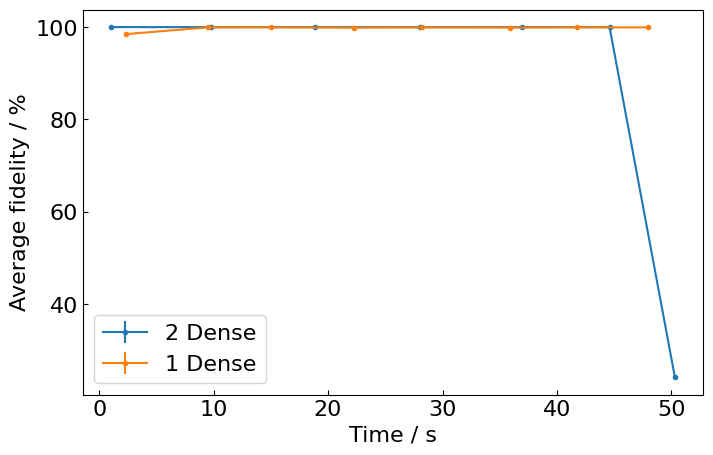

In [ ]:
plt.errorbar(times_saved2, fidelities2*100, yerr=fidelities_err2, linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved1, fidelities1*100, yerr=fidelities_err1, linestyle = '-', marker='.', label = '1 Dense')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

In [ ]:
print(f'Average fidelity over {len(tau_nns)} test matrices is {np.mean(fidelities)*100:.2f} ± {np.std(fidelities)*100/np.sqrt(len(fidelities)):.2f} %')

Average fidelity over 500 test matrices is 99.74 ± 0.17 %


In [ ]:
def build_cnn_model_3layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_3layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)                  │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 625)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 750)                 │         469,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,791 (3.11 MB)

 Trainable params: 814,791 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nvals3,all_taus3,rhos3 = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
time_callback3 = TimeHistory()

model3_layer = build_cnn_model_3layers()
model3_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver3 = InMemoryModelSaver(save_freq_epochs=10)

history3 = model3_layer.fit(
    nvals3, all_taus3,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping3, time_callback3, model_saver3]
    )

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0675 - mean_squared_error: 0.0194
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0654 - mean_squared_error: 0.0186 - val_loss: 0.0133 - val_mean_squared_error: 0.0011
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119 - mean_squared_error: 9.7762e-04 - val_loss: 0.0095 - val_mean_squared_error: 6.3131e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - mean_squared_error: 6.0594e-04 - val_loss: 0.0081 - val_mean_squared_error: 4.6207e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - mean_squared_error: 4.9777e-04 - val_loss: 0.0083 - val_mean_squared_error: 4.4004e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - mean_squared_error: 4.1190e-04 - val_loss: 0.0071 - val_mean_squared_error: 3.4794e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mean_squared_e

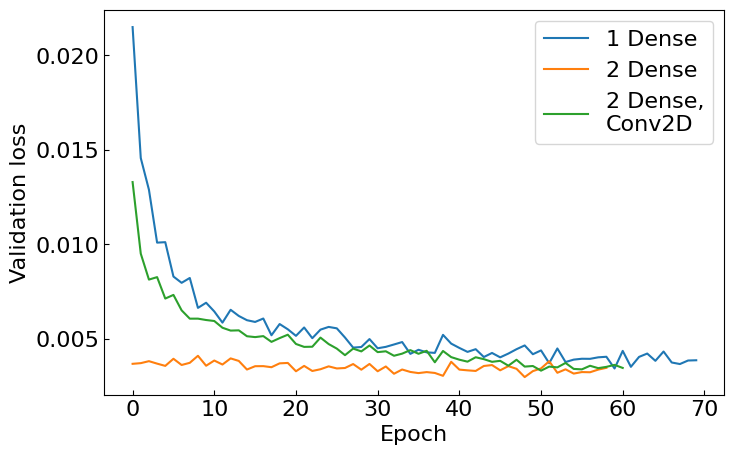

In [ ]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv2D')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

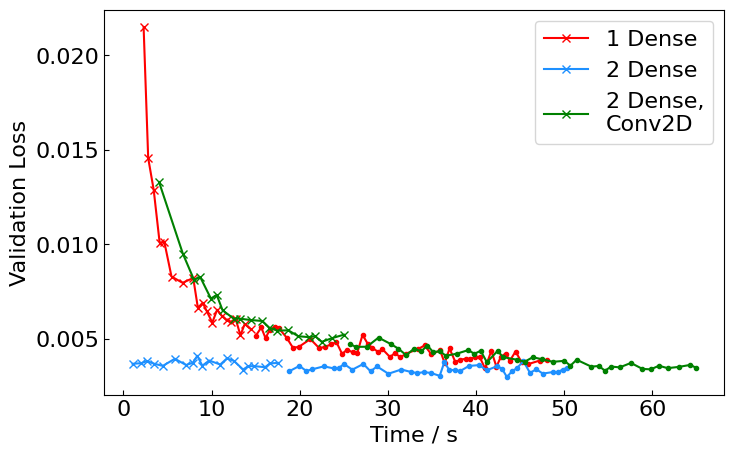

In [ ]:
cumulative_times3 = time_callback3.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv2D', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
n_tests3, tau_tests3, rho_tests3 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
epochs3 = len(history3.history['val_loss'])
epochs_saved3 = np.arange(1,epochs3,10)

In [ ]:
tau_nns_int3 = predict_with_saved_models(model_saver3.saved_models, epochs_saved3, n_tests3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
tau_nns3 = model3_layer.predict(n_tests3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
times_saved3, fidelities3, fidelities_err3 = fidelities_epochs(tau_nns3, tau_tests3, tau_nns_int3, epochs_saved3, epochs3, cumulative_times3)

Fidelities Plot (Per Saved Epoch): [0.99412602 0.99925911 0.99964763 0.99974617 0.99983231 0.99994942]
Overall Fidelity (fid): 0.9999494150578091
Epochs to Plot: [ 1 11 21 31 41 51 61]
Times Saved: [ 4.05549383 15.7631526  25.66654348 35.13282418 44.58738804 54.59683537
 64.95917034]


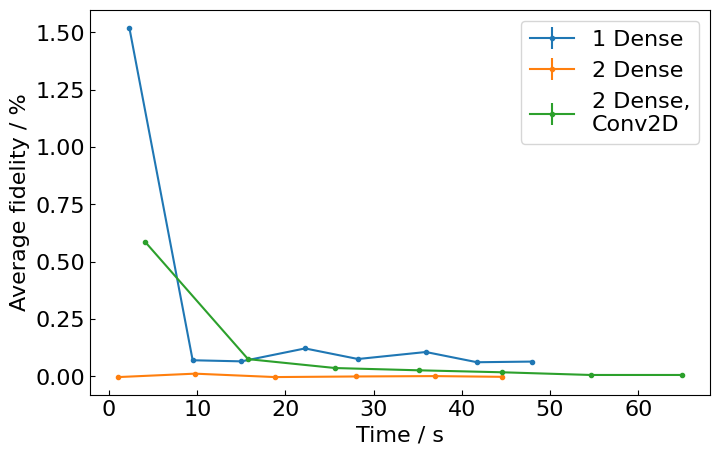

In [ ]:
plt.errorbar(times_saved1, (1-fidelities1)*100, yerr=fidelities_err1, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (1-fidelities2[:-1])*100, yerr=fidelities_err2[:-1], linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (1-fidelities3)*100, yerr=fidelities_err3, linestyle = '-', marker='.', label = '2 Dense,\nConv2D')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

In [ ]:
1-fidelities3

array([5.87398333e-03, 7.40887110e-04, 3.52367058e-04, 2.53828459e-04,
       1.67689356e-04, 5.05849422e-05, 5.05849422e-05])

In [ ]:
def build_cnn_model_4layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_4layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)                  │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 750)                 │          75,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,041 (1.61 MB)

 Trainable params: 421,041 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nvals4,all_taus4,rhos4 = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
time_callback4 = TimeHistory()

model4_layer = build_cnn_model_4layers()
model4_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver4 = InMemoryModelSaver(save_freq_epochs=10)

history4 = model4_layer.fit(
    nvals3, all_taus3,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback4, model_saver4]
    )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1143 - mean_squared_error: 0.0435
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1142 - mean_squared_error: 0.0434 - val_loss: 0.0812 - val_mean_squared_error: 0.0263
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0768 - mean_squared_error: 0.0241 - val_loss: 0.0653 - val_mean_squared_error: 0.0182
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0607 - mean_squared_error: 0.0161 - val_loss: 0.0523 - val_mean_squared_error: 0.0120
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0509 - mean_squared_error: 0.0117 - val_loss: 0.0465 - val_mean_squared_error: 0.0096
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0444 - mean_squared_error: 0.0091 - val_loss: 0.0407 - val_mean_squared_error: 0.0076
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0389 - mean_squared_error: 0.0073 - val_l

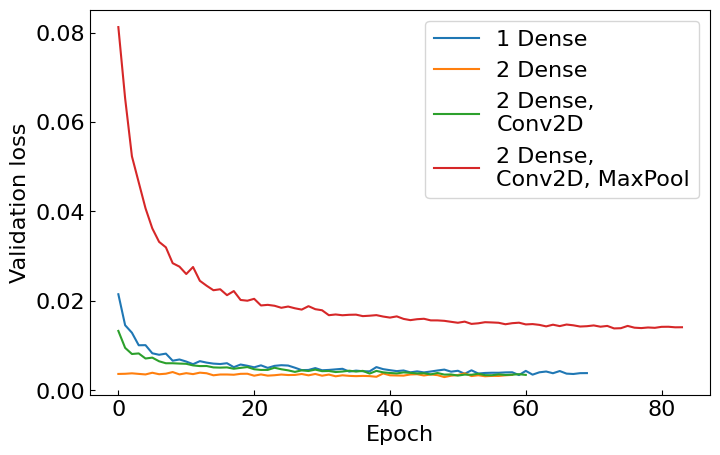

In [ ]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv2D')
plt.plot(history4.history['val_loss'], label='2 Dense,\nConv2D, MaxPool')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

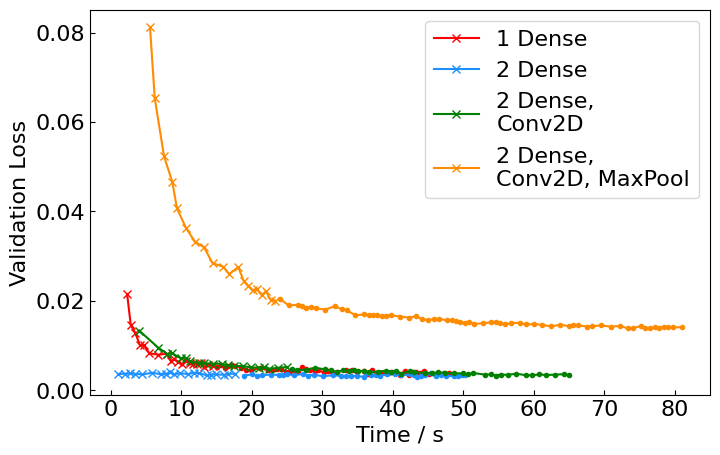

In [ ]:
cumulative_times4 = time_callback4.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv2D', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
n_tests4, tau_tests4, rho_tests4 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
epochs4 = len(history4.history['val_loss'])
epochs_saved4 = np.arange(1,epochs4,10)

In [ ]:
tau_nns_int4 = predict_with_saved_models(model_saver4.saved_models, epochs_saved4, n_tests4)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
tau_nns4 = model4_layer.predict(n_tests4)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
times_saved4, fidelities4, fidelities_err4 = fidelities_epochs(tau_nns4, tau_tests4, tau_nns_int4, epochs_saved4, epochs4, cumulative_times4)

In [ ]:
def build_cnn_model_5layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_5layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_12 (Reshape)                 │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 1, 1, 25)            │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 750)                 │          19,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 367,316 (1.40 MB)

 Trainable params: 367,316 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nvals5,all_taus5,rhos5 = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
time_callback5 = TimeHistory()

model5_layer = build_cnn_model_5layers()
model5_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver5 = InMemoryModelSaver(save_freq_epochs=10)

history5 = model5_layer.fit(
    nvals5, all_taus5,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback5, model_saver5]
    )

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1177 - mean_squared_error: 0.0468
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1174 - mean_squared_error: 0.0467 - val_loss: 0.0892 - val_mean_squared_error: 0.0301
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0847 - mean_squared_error: 0.0278 - val_loss: 0.0738 - val_mean_squared_error: 0.0227
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0714 - mean_squared_error: 0.0214 - val_loss: 0.0688 - val_mean_squared_error: 0.0201
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0642 - mean_squared_error: 0.0180 - val_loss: 0.0598 - val_mean_squared_error: 0.0161
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0577 - mean_squared_error: 0.0149 - val_loss: 0.0554 - val_mean_squared_error: 0.0139
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0537 - mean_squared_error: 0.0131 - val_loss: 0.0511 

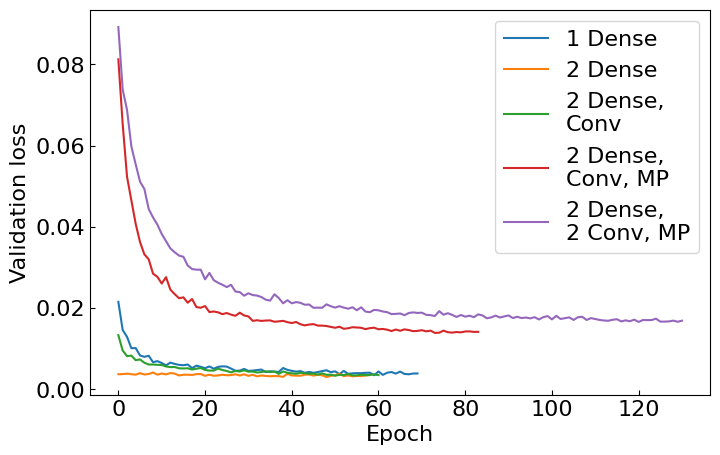

In [ ]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.plot(history4.history['val_loss'], label='2 Dense,\nConv, MP')
plt.plot(history5.history['val_loss'], label='2 Dense,\n2 Conv, MP')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

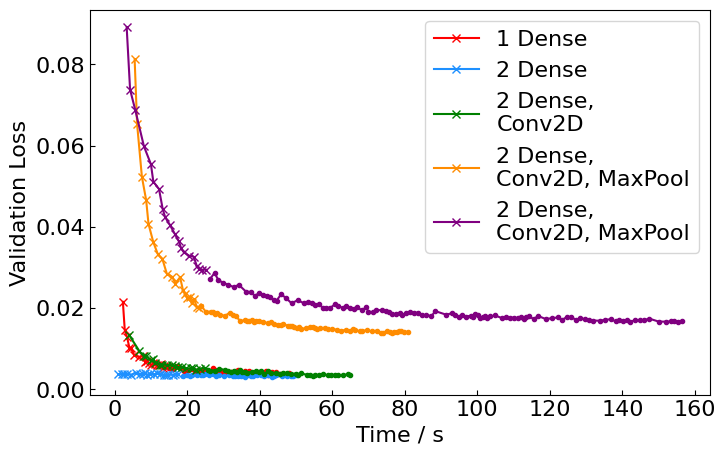

In [ ]:
cumulative_times5 = time_callback5.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv2D', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.plot(cumulative_times5[:20], history5.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='purple', linestyle='-', marker='x')
plt.plot(cumulative_times5[20:], history5.history['val_loss'][20:], color='purple', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
n_tests5, tau_tests5, rho_tests5 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
epochs5 = len(history5.history['val_loss'])
epochs_saved5 = np.arange(1,epochs5,10)

In [ ]:
tau_nns_int5 = predict_with_saved_models(model_saver5.saved_models, epochs_saved5, n_tests5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
tau_nns5 = model5_layer.predict(n_tests5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
times_saved5, fidelities5, fidelities_err5 = fidelities_epochs(tau_nns5, tau_tests5, tau_nns_int5, epochs_saved5, epochs5, cumulative_times5)

In [ ]:
def build_cnn_model_6layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(36,)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=25, kernel_size=(1, 1), strides=1, activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(dense1, activation='relu'))

    model.add(Dense(dense2, activation='relu'))

    model.add(Dense(2**(2*d), activation='linear'))

    return model

In [ ]:
def build_cnn_model_6layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 6, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
        strides=1
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(1, 1),
        activation='relu',
        strides=1
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_6layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_18 (Reshape)                 │ (None, 6, 6, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 5, 5, 25)            │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 2, 2, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 2, 2, 25)            │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 1, 1, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 750)                 │          19,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 450)                 │         337,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 16)                  │           7,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,441 (1.39 MB)

 Trainable params: 365,441 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nvals6,all_taus6,rhos6 = gen_nvals_taus_rhos(30000,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
time_callback6 = TimeHistory()

model6_layer = build_cnn_model_6layers()
model6_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver6 = InMemoryModelSaver(save_freq_epochs=10)

history6 = model6_layer.fit(
    nvals6, all_taus6,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback6, model_saver6]
    )

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


223/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1230 - mean_squared_error: 0.0502
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1225 - mean_squared_error: 0.0500 - val_loss: 0.1100 - val_mean_squared_error: 0.0435
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1088 - mean_squared_error: 0.0429 - val_loss: 0.1040 - val_mean_squared_error: 0.0403
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1035 - mean_squared_error: 0.0400 - val_loss: 0.1002 - val_mean_squared_error: 0.0380
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0995 - mean_squared_error: 0.0376 - val_loss: 0.0971 - val_mean_squared_error: 0.0363
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0961 - mean_squared_error: 0.0356 - val_loss: 0.0943 - val_mean_squared_error: 0.0346
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0936 - mean_squared_error: 0.0341 - val_loss: 0.0911 

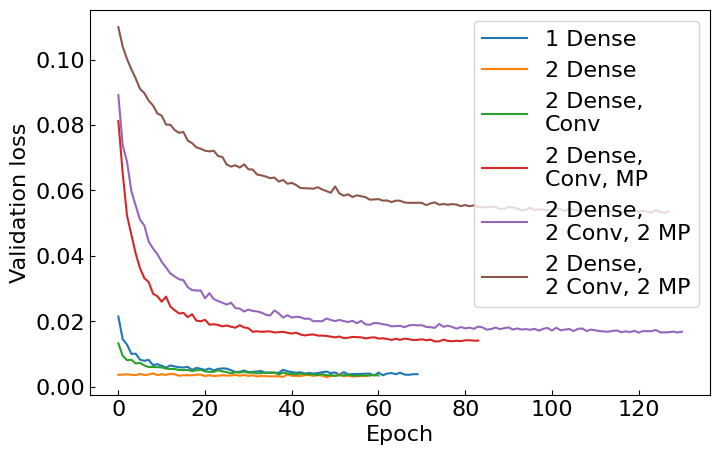

In [ ]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.plot(history4.history['val_loss'], label='2 Dense,\nConv, MP')
plt.plot(history5.history['val_loss'], label='2 Dense,\n2 Conv, 2 MP')
plt.plot(history6.history['val_loss'], label='2 Dense,\n2 Conv, 2 MP')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

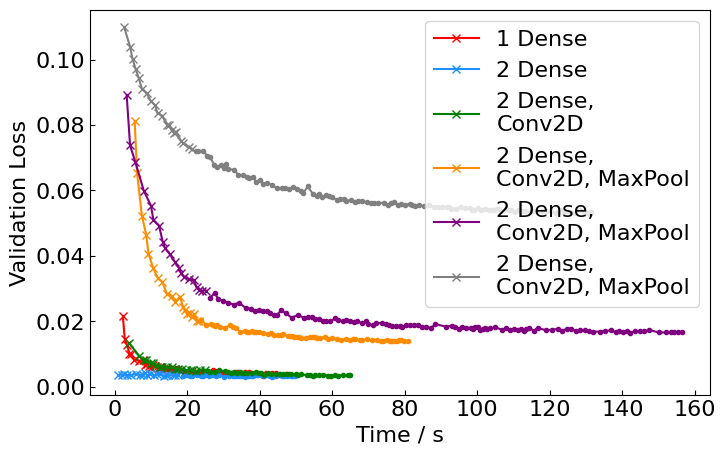

In [ ]:
cumulative_times6 = time_callback6.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv2D', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.plot(cumulative_times5[:20], history5.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='purple', linestyle='-', marker='x')
plt.plot(cumulative_times5[20:], history5.history['val_loss'][20:], color='purple', linestyle='-', marker='.')
plt.plot(cumulative_times6[:20], history6.history['val_loss'][:20], label='2 Dense,\nConv2D, MaxPool', color='gray', linestyle='-', marker='x')
plt.plot(cumulative_times6[20:], history6.history['val_loss'][20:], color='gray', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [ ]:
n_tests6, tau_tests6, rho_tests6 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-12-e382a3503c8c>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [ ]:
epochs6 = len(history6.history['val_loss'])
epochs_saved6 = np.arange(1,epochs6,10)

In [ ]:
tau_nns_int6 = predict_with_saved_models(model_saver6.saved_models, epochs_saved6, n_tests6)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
tau_nns6 = model6_layer.predict(n_tests6)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [ ]:
times_saved6, fidelities6, fidelities_err6 = fidelities_epochs(tau_nns6, tau_tests6, tau_nns_int6, epochs_saved6, epochs6, cumulative_times6)

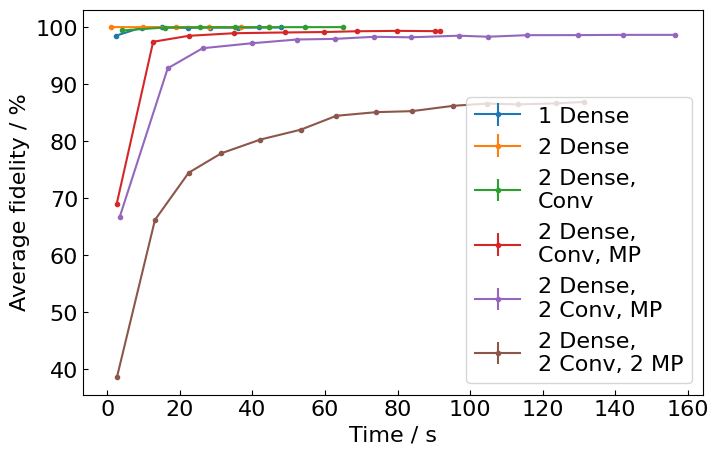

In [ ]:
plt.errorbar(times_saved1, (fidelities1)*100, yerr=fidelities_err1, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (fidelities2[:-1])*100, yerr=fidelities_err2[:-1], linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (fidelities3)*100, yerr=fidelities_err3, linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.errorbar(times_saved4, (fidelities4)*100, yerr=fidelities_err4, linestyle = '-', marker='.', label = '2 Dense,\nConv, MP')
plt.errorbar(times_saved5, (fidelities5)*100, yerr=fidelities_err5, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.errorbar(times_saved6, (fidelities6)*100, yerr=fidelities_err6, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, 2 MP')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

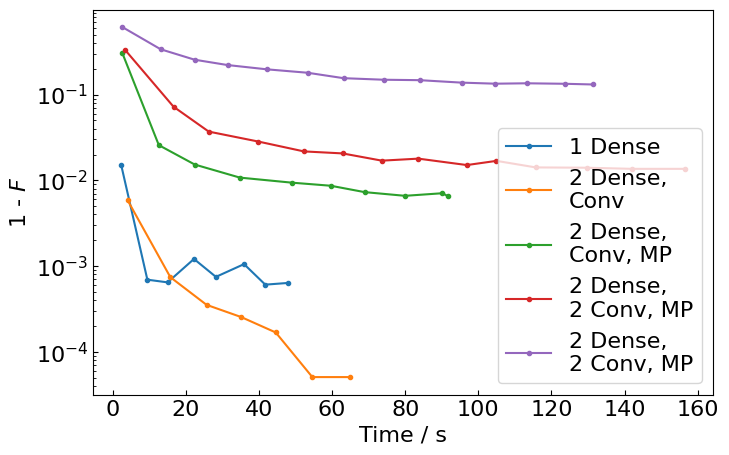

In [ ]:
plt.semilogy(times_saved1, (1-fidelities1), linestyle = '-', marker='.', label = '1 Dense')
# plt.semilogy(times_saved2, (1-fidelities2), linestyle = '-', marker='.', label = '2 Dense')
plt.semilogy(times_saved3, (1-fidelities3), linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.semilogy(times_saved4, (1-fidelities4), linestyle = '-', marker='.', label = '2 Dense,\nConv, MP')
plt.semilogy(times_saved5, (1-fidelities5), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.semilogy(times_saved6, (1-fidelities6), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.xlabel('Time / s')
plt.ylabel(r'1 - $F$')
plt.legend()
plt.show()

In [ ]:
save_dir = '/content/drive/MyDrive'

In [ ]:
import os

model_save_path = os.path.join(save_dir, '2d_trained_model.keras')

In [ ]:
model1.save(model_save_path)

In [ ]:
tau_nn = model.predict(nvals_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
print(no_data,d)

30000 2


In [ ]:
fidelity(test_rhos[0], rho_nn)

0.99948127099706151087